# CRISPR-Cas System and Off-target Prediciton with CNN

## Install necessary libraries
This cell installs specific versions of the following Python libraries:
- scikit-learn: For machine learning tasks like clustering and evaluation.
- torch and torchvision: For building and training neural networks (CNN).
- matplotlib: For data visualization and plotting.
- requests: For handling HTTP requests, e.g., downloading datasets.

The `-U` flag ensures that the latest compatible version is installed.


In [32]:
!pip install -U scikit-learn==1.3.2 torch==2.5.1 torchvision==0.20.1 matplotlib==3.9.2 requests

In [33]:
# For file handling, data fetching, and processing
import os
from requests import get

# For numerical operations
import math
import numpy as np
import pandas as pd

# For building and training deep learning models
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.utils.data import SubsetRandomSampler
import torch.nn as nn
from torch.nn import functional as F
import random
import matplotlib.pyplot as plt

# For evaluation and data splitting
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

## Configurable Constants
Define key constants for the notebook, such as file paths, model parameters, or dataset configurations.

In [34]:
# DATASET_FILE_URL: Link to the HEK cell dataset.
DATASET_FILE_URL = "https://github.com/BackofenLab/MLLS-exercise-SS22/raw/refs/heads/main/week_6/data/hg19_samples_hek.csv"

# DATASET_FILE_K562_URL: Link to the K562 cell dataset.
DATASET_FILE_K562_URL = "https://github.com/BackofenLab/MLLS-exercise-SS22/raw/refs/heads/main/week_6/data/hg19_samples_k562.csv"

# FOLD_NUM: Number of folds for k-fold cross-validation.
FOLD_NUM = 3

# EPOCH_NUM: Number of epochs for training the model.
EPOCH_NUM = 4

## Setup GPU
Check for GPU availability and ensures that the computations are optimized for CUDA if a compatible GPU is available

In [35]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Download dataset files

Checks if the required datasets (HEK and K562) are already present in the directory.

In [36]:
if not os.path.exists(DATASET_FILE_URL):
  open("hg19_samples_hek.csv", "wb").write(get(DATASET_FILE_URL).content)
  print("hg19_samples_hek file downloaded")
else:
  print("hg19_samples_hek file already exists")

if not os.path.exists(DATASET_FILE_K562_URL):
  open("hg19_samples_k562.csv", "wb").write(get(DATASET_FILE_K562_URL).content)
  print("hg19_samples_k562 file downloaded")
else:
  print("hg19_samples_k562 file already exists")

hg19_samples_hek file downloaded
hg19_samples_k562 file downloaded


## Dataset preparation
Loading, preprocessing, and preparing the scRNA-seq dataset for model training and evaluation.

In [37]:
# Define a custom Dataset class for loading and preprocessing the data.
class MyDataset(Dataset):
    # Initialize the dataset by loading, encoding, and combining HEK and K562 data.
    def __init__(self, dataset_file, dataset_file_k562):
        # Load HEK dataset and encode its sequences
        self.dataset_hek = pd.read_csv(dataset_file)
        self.x_value_hek = self.encode_data(np.array(self.dataset_hek["Guide-Seq"]), np.array(self.dataset_hek["false_seq"]))
        self.guide_hot_one_hek, self.target_hot_one_hek = self.hot_one_encoding(np.array(self.dataset_hek["Guide-Seq"]), np.array(self.dataset_hek["false_seq"]))
        self.y_value_hek = self.dataset_hek["label"]
        self.y_value_class_hek = self.y_value_hek

        # Load K562 dataset and encode its sequences
        self.dataset_k562 = pd.read_csv(dataset_file_k562)
        self.x_value_k562 = self.encode_data(np.array(self.dataset_k562["Guide-Seq"]), np.array(self.dataset_k562["false_seq"]))
        self.guide_hot_one_k562, self.target_hot_one_k562 = self.hot_one_encoding(np.array(self.dataset_k562["Guide-Seq"]), np.array(self.dataset_k562["false_seq"]))
        self.y_value_k562 = self.dataset_k562["label"]
        self.y_value_cass_k562 = [y + 2 for y in self.y_value_k562]

        # Combine HEK and K562 datasets
        self.full_dataset = []
        self.full_dataset.extend(self.dataset_hek)
        self.full_dataset.extend(self.dataset_k562)

        # Combine all features and labels from HEK and K562 datasets
        self.full_x_value = []
        self.full_x_value.extend(self.x_value_hek)
        self.full_x_value.extend(self.x_value_k562)

        self.full_y_value = []
        self.full_y_value.extend(self.y_value_hek)
        self.full_y_value.extend(self.y_value_k562)

        self.full_y_value_class = []
        self.full_y_value_class.extend(self.y_value_class_hek)
        self.full_y_value_class.extend(self.y_value_cass_k562)

        # Combine hot-one encoded sequences for guide and target
        self.full_guide_hot_one = []
        self.full_guide_hot_one.extend(self.guide_hot_one_hek)
        self.full_guide_hot_one.extend(self.guide_hot_one_k562)

        self.full_target_hot_one = []
        self.full_target_hot_one.extend(self.target_hot_one_hek)
        self.full_target_hot_one.extend(self.target_hot_one_k562)

        # Shuffle the combined dataset
        self.shuffle_all()

    def shuffle_all(self):
        # Shuffle all data to randomize the dataset
        shuffle_ind = list(range(len(self.full_y_value)))
        random.shuffle(shuffle_ind)

        # self.full_dataset = np.array(self.full_dataset)[shuffle_ind].tolist()

        # Shuffle features, labels, and hot-one encoded sequences
        self.full_x_value = torch.FloatTensor(np.array(self.full_x_value)[shuffle_ind].tolist())
        self.full_y_value = torch.LongTensor(np.array(self.full_y_value)[shuffle_ind].tolist())
        self.full_y_value_class = np.array(self.full_y_value_class)[shuffle_ind].tolist()
        self.full_guide_hot_one = np.array(self.full_guide_hot_one)[shuffle_ind].tolist()
        self.full_target_hot_one = np.array(self.full_target_hot_one)[shuffle_ind].tolist()

        return

    def __len__(self):
        # Return the total number of samples.
        return len(self.full_x_value)

    def __getitem__(self, idx):
        # Return a specific sample and its corresponding label.
        return (self.full_x_value[idx], self.full_guide_hot_one[idx], self.full_target_hot_one[idx]), self.full_y_value[idx]

    def return_class_y(self, indeces=[]):
        # Return class-adjusted labels for specified indices or the entire dataset.
        y_val = self.full_y_value_class

        if len(indeces) > 0:
            y_val = list(np.array(y_val)[indeces])

        return y_val

    def seperate_by_class(self, indeces):
        # Separate indices by class: HEK (0, 1) and K562 (2, 3).
        y_class_val = self.return_class_y(indeces=indeces)

        indeces_hek = [indeces[en] for en, z in enumerate(y_class_val) if z == 0 or z == 1]
        indeces_k562 = [indeces[en] for en, z in enumerate(y_class_val) if z == 2 or z == 3]

        return indeces_hek, indeces_k562

    def return_x(self):
        return self.full_x_value.tolist()

    def return_y(self, indeces=[]):
        y_val = self.full_y_value.tolist()

        if len(indeces) > 0:
            y_val = list(np.array(y_val)[indeces])

        return y_val

    def hot_one(self, seq):
        # Perform hot-one encoding for a single sequence.
        hot_one_dict = {"A": 0, "T": 1, "G": 2, "C": 3}
        hot_one = [[0, 0, 0, 0] for s in seq]
        for enum, s in enumerate(seq):
            hot_one[enum][hot_one_dict[s]] = 1

        return hot_one

    def hot_one_encoding(self, guide_seqs, seqs):
        # Perform hot-one encoding for guide and target sequences.
        hot_ones_target = []
        hot_ones_guide = []

        for en, guide in enumerate(guide_seqs):
            guide_hot_one = self.hot_one(guide)
            target_hot_one = self.hot_one(seqs[en])

            hot_ones_guide.append(guide_hot_one)
            hot_ones_target.append(target_hot_one)
        print(guide_seqs[0], seqs[0])
        print(hot_ones_guide[0], hot_ones_target[0])
        print("---")
        return torch.tensor(hot_ones_guide), torch.tensor(hot_ones_target)

    def encode_data(self, guide_seqs, seqs):
        # Encode sequences based on mismatches between guide and target sequences.
        encoded_seqs = []
        print(guide_seqs[0], seqs[0])
        for seq_num, seq in enumerate(seqs):
            encoded_seqs.append([float(1) if nuc1 != guide_seqs[seq_num][en] else float(0) for en, nuc1 in enumerate(seq)])
        return encoded_seqs


In [38]:
# Initialize the dataset with HEK and K562 samples
dataset = MyDataset("./hg19_samples_hek.csv", "./hg19_samples_k562.csv")

GGTGAGTGAGTGTGTGCGTGTGG CGTGTGTGTGTGCGTGTGTGTGC
GGTGAGTGAGTGTGTGCGTGTGG CGTGTGTGTGTGCGTGTGTGTGC
[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0]] [[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
---
CCAGTGAGTAGAGCGGAGGCAGG CCAGTGAGTGGAACGCCGTCGGG
CCAGTGAGTAGAGCGGAGGCAGG CCAGTGAGTGGAACGCCGTCGGG
[[0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1,

In [39]:
dataset.__getitem__(0)

((tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
          0., 0., 0., 0., 1.]),
  [[0, 0, 1, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [1, 0, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [1, 0, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 0, 0, 1],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 0, 1, 0]],
  [[0, 1, 0, 0],
   [0, 0, 1, 0],
   [1, 0, 0, 0],
   [0, 0, 1, 0],
   [1, 0, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 0, 0, 1],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0],
   [0, 0, 1, 0],
   [0, 1, 0, 0]]),
 tensor(0))

In [40]:
# Initialize the dataset with HEK and K562 samples
dataset = MyDataset("./hg19_samples_hek.csv", "./hg19_samples_k562.csv")

# Create indices for splitting the dataset into training and validation sets
indices = list(range(len(dataset)))  # Generate a list of all indices in the dataset
split = int(np.floor(0.3 * len(dataset)))  # Calculate the size of the validation set (30% of the dataset)
np.random.shuffle(indices)  # Shuffle the indices to randomize the dataset

# Initialize lists to store fold results and evaluation metrics
fold_res = []  # Stores results for each fold
average_precision_score_folds = []  # Stores average precision scores across folds

# Set up Stratified K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=False, random_state=None)


# Initialize lists to store AUPRC (Area Under Precision-Recall Curve) for HEK and K562 samples
# These lists are split based on three cross-validation folds
cv_list1_auprc_k562 = []  # Fold 1: AUPRC for K562 samples
cv_list2_auprc_k562 = []  # Fold 2: AUPRC for K562 samples
cv_list3_auprc_k562 = []  # Fold 3: AUPRC for K562 samples

cv_list1_auprc_hek = []  # Fold 1: AUPRC for HEK samples
cv_list2_auprc_hek = []  # Fold 2: AUPRC for HEK samples
cv_list3_auprc_hek = []  # Fold 3: AUPRC for HEK samples

GGTGAGTGAGTGTGTGCGTGTGG CGTGTGTGTGTGCGTGTGTGTGC
GGTGAGTGAGTGTGTGCGTGTGG CGTGTGTGTGTGCGTGTGTGTGC
[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0]] [[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
---
CCAGTGAGTAGAGCGGAGGCAGG CCAGTGAGTGGAACGCCGTCGGG
CCAGTGAGTAGAGCGGAGGCAGG CCAGTGAGTGGAACGCCGTCGGG
[[0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1,

In [41]:
def get_oversample_mask(indeces, dataset):
    """
      Generate an oversampled mask for imbalanced datasets.

      Args:
          indeces (list): List of sample indices to consider.
          dataset (MyDataset): The dataset object containing labels and data.

      Returns:
          list: A shuffled list of indices with oversampled positive samples.
    """
    full_list = []  # Initialize a list to store the oversampled indices

    y_val = dataset.return_y(indeces)  # Get the labels for the provided indices

    # Separate positive and negative sample indices
    pos_indeces = indeces[np.array([en for en, y in enumerate(y_val) if y == 1])]
    neg_indeces = indeces[np.array([en for en, y in enumerate(y_val) if y == 0])]

    # Calculate the number of negative samples (majority class)
    num_to_sample = len(neg_indeces)

    # Oversample positive samples to balance the dataset
    y_samples = []  # List to store the oversampled positive indices

    for i in range(math.ceil(num_to_sample / len(pos_indeces))): # Repeat positive indices until reaching the required number
        y_samples.extend(pos_indeces)

    y_samples = y_samples[:num_to_sample]  # Trim the oversampled positives to match the size of the negative samples

    # Combine oversampled positives and negatives
    full_list.extend(y_samples)  # Add oversampled positive indices
    full_list.extend(neg_indeces)  # Add all negative indices

    # Shuffle the combined list of indices
    random.shuffle(full_list)

    return full_list  # Return the shuffled oversampled indices

In [42]:
class cnn_net(nn.Module):
    def __init__(self):
        super(cnn_net, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=3)  # Input: single channel, Output: 6 feature maps

        # Define the second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3)  # Input: 6 feature maps, Output: 16 feature maps

        # Fully connected layers
        self.fc1 = nn.Linear(304, 60)  # Fully connected layer 1: Reduce features to 60
        self.fc2 = nn.Linear(60, 20)  # Fully connected layer 2: Reduce features to 20
        self.fc3 = nn.Linear(20, 1)  # Fully connected layer 3: Output a single value (binary classification)

        # Softmax layer (not used in this forward pass but available for multi-class classification)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_):
        """
        Forward pass of the network.

        Args:
            input_ (tuple): A tuple of input features, guide sequences, and target sequences.

        Returns:
            torch.Tensor: The sigmoid-activated output for binary classification.
        """
        x, guide, target = input_[0], input_[1], input_[2]  # Extract input components

        # Add a channel dimension for convolutional layers
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, sequence_length)

        # Apply the first convolutional layer followed by ReLU activation
        x = F.relu(self.conv1(x))

        # Apply the second convolutional layer followed by ReLU activation
        x = F.relu(self.conv2(x))

        # Flatten the output from the convolutional layers
        x = torch.flatten(x, 1)  # Shape: (batch_size, flattened_features)

        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))

        # Apply the second fully connected layer with ReLU activation
        x = F.relu(self.fc2(x))

        # Apply the final fully connected layer for binary classification
        x = self.fc3(x)

        # Apply sigmoid activation to produce probabilities for binary classification
        return torch.sigmoid(x)

In [43]:
class siamese_cnn_net(nn.Module):
    def __init__(self):
        super(siamese_cnn_net, self).__init__()

        # Define convolutional layers for the first head (mismatch features)
        self.conv1_head1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=3)  # Input: 1 channel, Output: 6 channels
        self.conv2_head1 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3)  # Input: 6 channels, Output: 16 channels

        # Define convolutional layers for the second head (target sequences)
        self.conv1_head2 = nn.Conv1d(in_channels=4, out_channels=6, kernel_size=3)  # Input: 4 channels, Output: 6 channels
        self.conv2_head2 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3)  # Input: 6 channels, Output: 16 channels

        # Fully connected layers
        self.fc1 = nn.Linear(608, 60)  # First fully connected layer
        self.fc2 = nn.Linear(60, 20)   # Second fully connected layer
        self.fc3 = nn.Linear(20, 1)   # Output layer for binary classification

    def forward(self, input_):
        """
        Forward pass for the Siamese CNN.

        Args:
            input_ (tuple): A tuple containing mismatches, guide, and target sequences.

        Returns:
            torch.Tensor: Output probabilities for binary classification.
        """
        mismatches, guide, target = input_[0], input_[1], input_[2]  # Extract inputs

        ### Head One (mismatch features)
        mismatches = mismatches.unsqueeze(1)  # Add channel dimension for convolution
        mismatches = F.relu(self.conv1_head1(mismatches))  # Apply first convolution + ReLU
        mismatches = F.relu(self.conv2_head1(mismatches))  # Apply second convolution + ReLU

        ### Head Two (target sequences)
        target = torch.stack([torch.stack(row) for row in target])
        target = target.float()
        target = torch.permute(target, (2, 1, 0))  # Rearrange dimensions for convolution (batch_size, channels, length)
        target = F.relu(self.conv1_head2(target))  # Apply first convolution + ReLU
        target = F.relu(self.conv2_head2(target))  # Apply second convolution + ReLU

        ### Combine Outputs
        x = torch.cat([mismatches, target], dim=1)  # Concatenate outputs along the channel dimension

        ### Fully Connected Layers
        x = torch.flatten(x, 1)  # Flatten the combined feature maps for the fully connected layers
        x = F.relu(self.fc1(x))  # Apply first fully connected layer + ReLU
        x = F.relu(self.fc2(x))  # Apply second fully connected layer + ReLU
        x = self.fc3(x)          # Apply final fully connected layer for classification

        return torch.sigmoid(x)  # Sigmoid activation to output probabilities

In [44]:
class sequence_cnn_net(nn.Module):
    def __init__(self):
        super(sequence_cnn_net, self).__init__()

        # Define convolutional layers for the guide sequence (Head 1)
        self.conv1_head1 = nn.Conv1d(in_channels=4, out_channels=6, kernel_size=3)  # Input: 4 channels (A, T, G, C), Output: 6 feature maps
        self.conv2_head1 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3)  # Input: 6 feature maps, Output: 16 feature maps

        # Define convolutional layers for the target sequence (Head 2)
        self.conv1_head2 = nn.Conv1d(in_channels=4, out_channels=6, kernel_size=3)  # Input: 4 channels (A, T, G, C), Output: 6 feature maps
        self.conv2_head2 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3)  # Input: 6 feature maps, Output: 16 feature maps

        # Define convolutional layers for mismatch features (Head 3)
        self.conv1_head3 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=3)  # Input: 1 channel, Output: 6 feature maps
        self.conv2_head3 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3)  # Input: 6 feature maps, Output: 16 feature maps

        # Fully connected layers
        self.fc1 = nn.Linear(912, 60)  # First fully connected layer
        self.fc2 = nn.Linear(60, 20)   # Second fully connected layer
        self.fc3 = nn.Linear(20, 1)   # Output layer for binary classification


    def forward(self, input_):
        """
        Forward pass for the Sequence CNN.

        Args:
            input_ (tuple): A tuple containing mismatches, guide, and target sequences.

        Returns:
            torch.Tensor: Output probabilities for binary classification.
        """
        mismatches, guide, target = input_[0], input_[1], input_[2]  # Extract inputs

        ### Head One (Guide Sequence)
        guide = torch.stack([torch.stack(row) for row in guide])
        guide = guide.float()
        guide = torch.permute(guide, (2, 1, 0))  # Rearrange dimensions for convolution (batch_size, channels, length)
        guide = F.relu(self.conv1_head1(guide))  # Apply first convolution + ReLU
        guide = F.relu(self.conv2_head1(guide))  # Apply second convolution + ReLU

        ### Head Two (Target Sequence)
        target = torch.stack([torch.stack(row) for row in target])
        target = target.float()
        target = torch.permute(target, (2, 1, 0))  # Rearrange dimensions for convolution (batch_size, channels, length)
        target = F.relu(self.conv1_head2(target))  # Apply first convolution + ReLU
        target = F.relu(self.conv2_head2(target))  # Apply second convolution + ReLU

        ### Head Three (Mismatch Features)
        mismatches = mismatches.unsqueeze(1)  # Add channel dimension for convolution
        mismatches = F.relu(self.conv1_head3(mismatches))  # Apply first convolution + ReLU
        mismatches = F.relu(self.conv2_head3(mismatches))  # Apply second convolution + ReLU

        ### Combine Outputs
        x = torch.cat([guide, target, mismatches], dim=1)  # Concatenate outputs along the channel dimension

        ### Fully Connected Layers
        x = torch.flatten(x, 1)  # Flatten the combined feature maps for the fully connected layers
        x = F.relu(self.fc1(x))  # Apply first fully connected layer + ReLU
        x = F.relu(self.fc2(x))  # Apply second fully connected layer + ReLU
        x = self.fc3(x)          # Apply final fully connected layer for classification

        return torch.sigmoid(x)  # Sigmoid activation to output probabilities

In [45]:
def train(trainloader, net, criterion, optimizer, epoch):
    """
    Training loop for a single epoch.

    Args:
        trainloader (DataLoader): DataLoader for the training dataset.
        net (nn.Module): The neural network model.
        criterion (nn.Module): The loss function (e.g., BCEWithLogitsLoss or MSELoss).
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        epoch (int): Current epoch number (for logging or scheduling purposes).

    Returns:
        net (nn.Module): The updated model after one epoch of training.
        running_loss (float): The cumulative loss for this epoch.
    """
    running_loss = 0.0  # Initialize the cumulative loss for the epoch

    for i, data in enumerate(trainloader):
        # Unpack the batch: inputs (features) and labels (ground truth)
        inputs, labels = data

        # Reset gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass: compute model outputs
        outputs = net(inputs)

        # Reshape labels to match the output dimension for loss computation
        labels = labels.view(-1).float()

        # Compute the loss between predictions and ground truth
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass: compute gradients
        loss.backward()

        # Update model parameters using the optimizer
        optimizer.step()

        # Accumulate loss for reporting
        running_loss += loss.item()

    # Return the updated model and the total loss for the epoch
    return net, running_loss

In [46]:
def evaluate(dataloader, net, criterion, epoch):
    """
    Evaluate the model on the validation/test dataset.

    Args:
        dataloader (DataLoader): DataLoader for the validation/test dataset.
        net (nn.Module): The neural network model to be evaluated.
        criterion (nn.Module): The loss function (e.g., BCEWithLogitsLoss).
        epoch (int): Current epoch number (for logging purposes).

    Returns:
        tuple: A tuple containing:
            - y_values (list): Ground truth labels.
            - predicted_list (list): Model predictions (probabilities or binary labels).
            - running_loss (float): Cumulative loss over the evaluation dataset.
            - mean_eval (float): Mean average precision score (AUPRC) across the dataset.
            - mean_eval_auroc (float): Mean Area Under ROC Curve (AUROC) score across the dataset.
    """
    correct = 0  # Track the number of correct predictions
    y_values = []  # Store ground truth labels
    running_loss = 0.0  # Cumulative loss for the evaluation phase
    predicted_list = []  # Store predicted probabilities or binary labels
    evals = []  # Store Average Precision Score (AUPRC) for each batch
    evals_auroc = []  # Store AUROC score for each batch

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for data in dataloader:
            # Unpack the batch: inputs (features) and labels (ground truth)
            inputs, labels = data
            labels_save = labels  # Save original labels for comparison later

            # Forward pass: compute model outputs
            outputs = net(inputs)
            labels = labels.view(-1).float()  # Reshape labels for loss computation

            # Compute the loss
            loss = criterion(outputs.squeeze(), labels)

            # Generate binary predictions (0 or 1 based on 0.5 threshold)
            predicted = [0 if p < 0.5 else 1 for p in outputs.data]

            # Append raw outputs (probabilities) to the predicted list
            predicted_list.extend(outputs.data.tolist())

            # Append ground truth labels to the y_values list
            y_values.extend(labels.tolist())

            # Accumulate the total loss
            running_loss += loss.item()

            # Compute AUPRC (Average Precision Score) for the batch
            eval_ = average_precision_score(labels.tolist(), outputs.data.tolist())
            evals.append(eval_)

            # Compute AUROC (Area Under ROC Curve) for the batch
            eval_auroc = roc_auc_score(labels.tolist(), outputs.data.tolist())
            evals_auroc.append(eval_auroc)

    # Return evaluation metrics
    return y_values, predicted_list, running_loss, np.mean(evals), np.mean(evals_auroc)

In [47]:
def plot_metric(epoch, predicted_list1_full, predicted_list2_full, predicted_list3_full, labels):


	fig, ax = plt.subplots(figsize=(3, 3))

	ax.set_title('AUPRC on validation set', color='C0')

	ax.plot(list(range(epoch+1)), predicted_list1_full, 'C1', label=labels[0])
	ax.plot(list(range(epoch+1)), predicted_list2_full, 'C2', label=labels[1])
	ax.plot(list(range(epoch+1)), predicted_list3_full, 'C3', label=labels[2])
	ax.set_xlabel("epochs")
	ax.set_ylabel("AUPRC")
	ax.legend()
	
	plt.show()



	return

Processing fold 0
  Epoch 0
cnn-net: AUPRC in epoch 0: 0.4668239502882977,  AUROC: 0.9858748172303828, val-Loss:  0.160, train-loss: 0.227
siamese-net: AUPRC in epoch 0: 0.5482446152040887,  AUROC: 0.9930212509476017, val-Loss:  0.111, train-loss: 0.147
sequence_cnn_net: AUPRC in epoch 0: 0.5665348735597168, AUROC: 0.9935531413705071, val-Loss:  0.092, train-loss: 0.155
##############################################################################################
  Epoch 1
cnn-net: AUPRC in epoch 1: 0.47385971646674657,  AUROC: 0.9878613637863798, val-Loss:  0.159, train-loss: 0.121
siamese-net: AUPRC in epoch 1: 0.6068828988324159,  AUROC: 0.9941037004638498, val-Loss:  0.070, train-loss: 0.067
sequence_cnn_net: AUPRC in epoch 1: 0.6037029282987925, AUROC: 0.9938966782434648, val-Loss:  0.062, train-loss: 0.060
##############################################################################################
  Epoch 2
cnn-net: AUPRC in epoch 2: 0.4868214828135117,  AUROC: 0.98807338654348

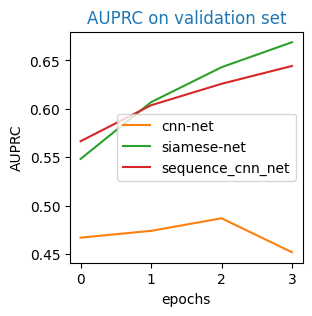

#######################################################################
TEST ON HEK CELL LINE
#######################################################################
cnn-net: AUPRC in fold 0: 0.5313027047085223 , Test-Loss:  0.069
siamese-net: AUPRC in fold 0:  0.6521978082245737, Test-Loss:  0.046
sequence_cnn_net: AUPRC in fold 0:  0.6368357834298186, Test-Loss:  0.048
#######################################################################
#######################################################################
TEST ON K562 CELL LINE
#######################################################################
cnn-net: AUPRC in fold 0: 0.5005140311978847 , Test-Loss:  0.135
siamese-net: AUPRC in fold 0:  0.5776045556628413, Test-Loss:  0.076
sequence_cnn_net: AUPRC in fold 0:  0.599515313242465, Test-Loss:  0.058
#######################################################################
Processing fold 1
  Epoch 0
cnn-net: AUPRC in epoch 0: 0.21591827631384486,  AUROC: 0.9516203488071211, val-

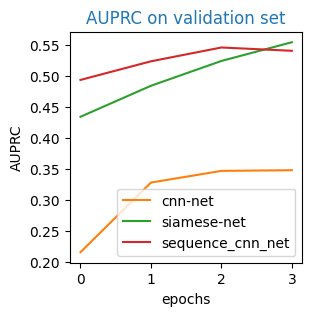

#######################################################################
TEST ON HEK CELL LINE
#######################################################################
cnn-net: AUPRC in fold 1: 0.4269483381200828 , Test-Loss:  0.106
siamese-net: AUPRC in fold 1:  0.6404832108701022, Test-Loss:  0.043
sequence_cnn_net: AUPRC in fold 1:  0.6447001101571385, Test-Loss:  0.031
#######################################################################
#######################################################################
TEST ON K562 CELL LINE
#######################################################################
cnn-net: AUPRC in fold 1: 0.5307455673739404 , Test-Loss:  0.146
siamese-net: AUPRC in fold 1:  0.5678585914803614, Test-Loss:  0.046
sequence_cnn_net: AUPRC in fold 1:  0.5410341628016343, Test-Loss:  0.041
#######################################################################
Processing fold 2
  Epoch 0
cnn-net: AUPRC in epoch 0: 0.5243416129711463,  AUROC: 0.9893518700593857, val-

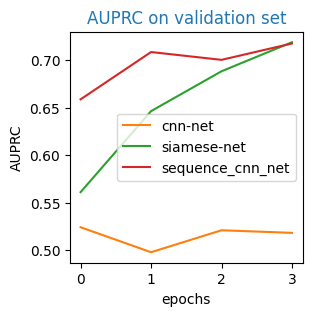

#######################################################################
TEST ON HEK CELL LINE
#######################################################################
cnn-net: AUPRC in fold 2: 0.36847547853085777 , Test-Loss:  0.096
siamese-net: AUPRC in fold 2:  0.5829101186753792, Test-Loss:  0.045
sequence_cnn_net: AUPRC in fold 2:  0.5774923770901664, Test-Loss:  0.028
#######################################################################
#######################################################################
TEST ON K562 CELL LINE
#######################################################################
cnn-net: AUPRC in fold 2: 0.7097024909525805 , Test-Loss:  0.153
siamese-net: AUPRC in fold 2:  0.7745937948002972, Test-Loss:  0.048
sequence_cnn_net: AUPRC in fold 2:  0.7852703533810079, Test-Loss:  0.027
#######################################################################


In [48]:
for enum, indeces in enumerate(kfold.split(dataset.return_x(), dataset.return_class_y())):
        print(f"Processing fold {enum}")

        train_indices, test_val_ind = indeces[0], indeces[1]

        split2 = int(np.floor(0.5 * len(test_val_ind)))
        val_indices, test_indices = test_val_ind[split2:], test_val_ind[:split2]

        train_oversample_mask = get_oversample_mask(train_indices, dataset)

        train_sampler = SubsetRandomSampler(train_oversample_mask)
        valid_sampler = SubsetRandomSampler(val_indices)

        test_indices_hek, test_indices_k562 = dataset.seperate_by_class(test_indices)

        test_sampler_hek = SubsetRandomSampler(test_indices_hek)
        test_sampler_k562 = SubsetRandomSampler(test_indices_k562)

        train_loader = DataLoader(dataset, batch_size=30, sampler=train_sampler)
        validation_loader = DataLoader(
            dataset, batch_size=len(val_indices), sampler=valid_sampler
        )

        test_loader_hek = DataLoader(
            dataset, batch_size=len(test_indices), sampler=test_sampler_hek
        )
        test_loader_k562 = DataLoader(
            dataset, batch_size=len(test_indices), sampler=test_sampler_k562
        )

        net = cnn_net()
        saved_cnn_net = cnn_net()
        optimizer1 = torch.optim.Adam(net.parameters(), lr=0.0001)
        criterion1 = nn.BCELoss()
        siamese_net = siamese_cnn_net()
        saved_siamese_net = siamese_cnn_net()
        optimizer2 = torch.optim.Adam(siamese_net.parameters(), lr=0.0001)
        criterion2 = nn.BCELoss()
        sequence_net = sequence_cnn_net()
        saved_sequence_cnn_net = sequence_cnn_net()
        optimizer3 = torch.optim.Adam(sequence_net.parameters(), lr=0.0001)
        criterion3 = nn.BCELoss()

        y_value_list = []
        predicted_list1_full = []
        predicted_list2_full = []
        predicted_list3_full = []

        predicted_list1_auroc = []
        predicted_list2_auroc = []
        predicted_list3_auroc = []

        best_validation_cnn_net = np.inf
        best_validation_siamese_cnn_net = np.inf
        best_validation_sequence_cnn_net = np.inf

        for epoch in range(EPOCH_NUM):
            print(f"  Epoch {epoch}")

            # Train CNN
            net, running_loss_train1 = train(
                train_loader,
                net=net,
                criterion=criterion1,
                optimizer=optimizer1,
                epoch=epoch,
            )
            y_values1, predicted_list1, running_loss1, eval_1, eval_auroc_1 = evaluate(
                validation_loader, net, criterion=criterion1, epoch=epoch
            )

            # Train Siamese CNN
            siamese_net, running_loss_train2 = train(
                train_loader,
                net=siamese_net,
                criterion=criterion2,
                optimizer=optimizer2,
                epoch=epoch,
            )
            y_values2, predicted_list2, running_loss2, eval_2, eval_auroc_2 = evaluate(
                validation_loader, siamese_net, criterion=criterion2, epoch=epoch
            )

            # Train Sequence CNN
            sequence_net, running_loss_train3 = train(
                train_loader,
                net=sequence_net,
                criterion=criterion3,
                optimizer=optimizer3,
                epoch=epoch,
            )
            y_values3, predicted_list3, running_loss3, eval_3, eval_auroc_3 = evaluate(
                validation_loader, sequence_net, criterion=criterion3, epoch=epoch
            )

            y_value_list.extend(y_values1)
            predicted_list1_full.append(eval_1)
            predicted_list2_full.append(eval_2)
            predicted_list3_full.append(eval_3)
            predicted_list1_auroc.append(eval_auroc_1)
            predicted_list2_auroc.append(eval_auroc_2)
            predicted_list3_auroc.append(eval_auroc_3)

            if running_loss1 <= best_validation_cnn_net:
                best_validation_cnn_net = running_loss1
                saved_cnn_net.load_state_dict(net.state_dict())

            if running_loss2 <= best_validation_siamese_cnn_net:
                best_validation_siamese_cnn_net = running_loss2
                saved_siamese_net.load_state_dict(siamese_net.state_dict())

            if running_loss3 <= best_validation_sequence_cnn_net:
                best_validation_sequence_cnn_net = running_loss3
                saved_sequence_cnn_net.load_state_dict(sequence_net.state_dict())

            print(f"cnn-net: AUPRC in epoch {epoch}: {np.mean(eval_1)},  AUROC: {np.mean(eval_auroc_1)}, val-Loss:  {running_loss1 / len(validation_loader):.3f}, train-loss: {running_loss_train1 / len(train_loader):.3f}")
            print(f"siamese-net: AUPRC in epoch {epoch}: {np.mean(eval_2)},  AUROC: {np.mean(eval_auroc_2)}, val-Loss:  {running_loss2 / len(validation_loader):.3f}, train-loss: {running_loss_train2 / len(train_loader):.3f}")
            print(f"sequence_cnn_net: AUPRC in epoch {epoch}: {np.mean(eval_3)}, AUROC: {np.mean(eval_auroc_3)}, val-Loss:  {running_loss3 / len(validation_loader):.3f}, train-loss: {running_loss_train3 / len(train_loader):.3f}")
            print("##############################################################################################")

        print("END OF TRAINING")

        plot_metric(epoch, predicted_list1_full, predicted_list2_full, predicted_list3_full, ["cnn-net","siamese-net","sequence_cnn_net"])

        print("#######################################################################")
        print("TEST ON HEK CELL LINE")
        print("#######################################################################")

        #### final test #####
        y_values1, predicted_list1, running_loss1, eval_1, eval_auroc_1 = evaluate(
            test_loader_hek, saved_cnn_net, criterion=criterion1, epoch=epoch
        )
        y_values2, predicted_list2, running_loss2, eval_2, eval_auroc_2 = evaluate(
            test_loader_hek, saved_siamese_net, criterion=criterion2, epoch=epoch
        )
        y_values3, predicted_list3, running_loss3, eval_3, eval_auroc_3 = evaluate(
            test_loader_hek, saved_sequence_cnn_net, criterion=criterion3, epoch=epoch
        )

        cv_list1_auprc_hek.append(eval_1)
        cv_list2_auprc_hek.append(eval_2)
        cv_list3_auprc_hek.append(eval_3)

        print(f"cnn-net: AUPRC in fold {enum}: {np.mean(eval_1)} , Test-Loss:  {running_loss1 / len(test_loader_hek):.3f}")
        print(f"siamese-net: AUPRC in fold {enum}:  {np.mean(eval_2)}, Test-Loss:  {running_loss2 / len(test_loader_hek):.3f}")
        print(f"sequence_cnn_net: AUPRC in fold {enum}:  {np.mean(eval_3)}, Test-Loss:  {running_loss3 / len(test_loader_hek):.3f}")
        print("#######################################################################")

        #### final test #####
        y_values1, predicted_list1, running_loss1, eval_1, eval_auroc_1 = evaluate(
            test_loader_k562, saved_cnn_net, criterion=criterion1, epoch=epoch
        )
        y_values2, predicted_list2, running_loss2, eval_2, eval_auroc_2 = evaluate(
            test_loader_k562, saved_siamese_net, criterion=criterion2, epoch=epoch
        )
        y_values3, predicted_list3, running_loss3, eval_3, eval_auroc_3 = evaluate(
            test_loader_k562, saved_sequence_cnn_net, criterion=criterion3, epoch=epoch
        )

        cv_list1_auprc_k562.append(eval_1)
        cv_list2_auprc_k562.append(eval_2)
        cv_list3_auprc_k562.append(eval_3)

        print("#######################################################################")
        print("TEST ON K562 CELL LINE")
        print("#######################################################################")
        print(f"cnn-net: AUPRC in fold {enum}: {np.mean(eval_1)} , Test-Loss:  {running_loss1 / len(test_loader_k562):.3f}")
        print(f"siamese-net: AUPRC in fold {enum}:  {np.mean(eval_2)}, Test-Loss:  {running_loss2 / len(test_loader_k562):.3f}")
        print(f"sequence_cnn_net: AUPRC in fold {enum}:  {np.mean(eval_3)}, Test-Loss:  {running_loss3 / len(test_loader_k562):.3f}")
        print("#######################################################################")

In [49]:
# Loop through each fold's results for HEK and K562
for num, auprc in enumerate(cv_list1_auprc_hek):
    # Report results for HEK Cell Line
    print("#######################################################################")
    print("TEST ON HEK CELL LINE")
    print("#######################################################################")
    print(f"cnn-net: AUPRC in fold {num}: {np.mean(auprc):.3f}")
    print(f"siamese-net: AUPRC in fold {num}:  {np.mean(cv_list2_auprc_hek[num]):.3f}")
    print(f"sequence_cnn_net: AUPRC in fold {num}:  {np.mean(cv_list3_auprc_hek[num]):.3f}")
    print("#######################################################################")

    # Report results for K562 Cell Line
    print("#######################################################################")
    print("TEST ON K562 CELL LINE")
    print("#######################################################################")
    print(f"cnn-net: AUPRC in fold {num}: {np.mean(cv_list1_auprc_k562[num]):.3f}")
    print(f"siamese-net: AUPRC in fold {num}:  {np.mean(cv_list2_auprc_k562[num]):.3f}")
    print(f"sequence_cnn_net: AUPRC in fold {num}:  {np.mean(cv_list3_auprc_k562[num]):.3f}")
    print("#######################################################################")

# Report average results across all folds for HEK Cell Line
print("#######################################################################")
print("TEST ON HEK CELL LINE")
print("#######################################################################")
print(f"cnn-net: Average AUPRC over all folds: {np.mean(cv_list1_auprc_hek):.3f}")
print(f"siamese-net: Average AUPRC over all folds: {np.mean(cv_list2_auprc_hek):.3f}")
print(f"sequence_cnn_net: Average AUPRC over all folds: {np.mean(cv_list3_auprc_hek):.3f}")
print("#######################################################################")

# Report average results across all folds for K562 Cell Line
print("#######################################################################")
print("TEST ON K562 CELL LINE")
print("#######################################################################")
print(f"cnn-net: Average AUPRC over all folds: {np.mean(cv_list1_auprc_k562):.3f}")
print(f"siamese-net: Average AUPRC over all folds: {np.mean(cv_list2_auprc_k562):.3f}")
print(f"sequence_cnn_net: Average AUPRC over all folds: {np.mean(cv_list3_auprc_k562):.3f}")
print("#######################################################################")

#######################################################################
TEST ON HEK CELL LINE
#######################################################################
cnn-net: AUPRC in fold 0: 0.531
siamese-net: AUPRC in fold 0:  0.652
sequence_cnn_net: AUPRC in fold 0:  0.637
#######################################################################
#######################################################################
TEST ON K562 CELL LINE
#######################################################################
cnn-net: AUPRC in fold 0: 0.501
siamese-net: AUPRC in fold 0:  0.578
sequence_cnn_net: AUPRC in fold 0:  0.600
#######################################################################
#######################################################################
TEST ON HEK CELL LINE
#######################################################################
cnn-net: AUPRC in fold 1: 0.427
siamese-net: AUPRC in fold 1:  0.640
sequence_cnn_net: AUPRC in fold 1:  0.645
########################